In [12]:
import xarray as xr
import pandas as pd
from eofs.xarray import Eof
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/z3526974/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fill', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
#define function to do correlation with confidence intervals and significance
import numpy as np
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [14]:
fname = '/home/z3526974/Work/data/dipole_work/IMOS_altimetry_EAC_region_1993_2019/IMOS_aggregation_20190307T030559Z.nc'
ds = xr.open_dataset(fname)
# interpolate to daily
ds = ds.resample(TIME='1D').interpolate('linear')

In [15]:
#get mean of sea level
mean_SL = ds.GSLA.mean(dim='TIME')
mean_SL

/home/z3526974/anaconda2/envs/py36/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'GSLA' (LATITUDE: 36, LONGITUDE: 31)>
array([[ 0.020841,  0.0164  ,  0.010813, ...,  0.00432 ,  0.011932,  0.018699],
       [ 0.021443,  0.018439,  0.014391, ..., -0.001258,  0.008231,  0.016957],
       [      nan,  0.020778,  0.018527, ..., -0.005759,  0.0043  ,  0.013378],
       ...,
       [      nan,       nan,       nan, ...,  0.004836,  0.008798,  0.014481],
       [      nan,       nan,       nan, ...,  0.001725,  0.004572,  0.008517],
       [      nan,       nan,       nan, ..., -0.000148,  0.00164 ,  0.003919]])
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 150.0 150.2 150.4 150.6 ... 155.6 155.8 156.0
  * LATITUDE   (LATITUDE) float32 -37.0 -36.8 -36.6 -36.4 ... -30.4 -30.2 -30.0

In [16]:
# Set up solver (need to give it the right coordinates and variables to  match the dataset)
coslat = np.cos(np.deg2rad(ds.coords['LATITUDE'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(ds.GSL, weights=wgts)

In [17]:
# Retrieve the first 5 EOFs, expressed as the correlation between the leading
# PC time series and the input sea level anomalies at each grid point, and the
# leading PC time series itself.
eof1 = solver.eofs(neofs=5)
pc1 = solver.pcs(npcs=2, pcscaling=1)
eof_frac=solver.varianceFraction()
eof_frac

<xarray.DataArray 'variance_fractions' (mode: 1116)>
array([1.799833e-01, 1.636075e-01, 1.234538e-01, ..., 1.693393e-11,
       1.679531e-11, 1.662331e-11])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 ... 1109 1110 1111 1112 1113 1114 1115
Attributes:
    long_name:  variance_fractions

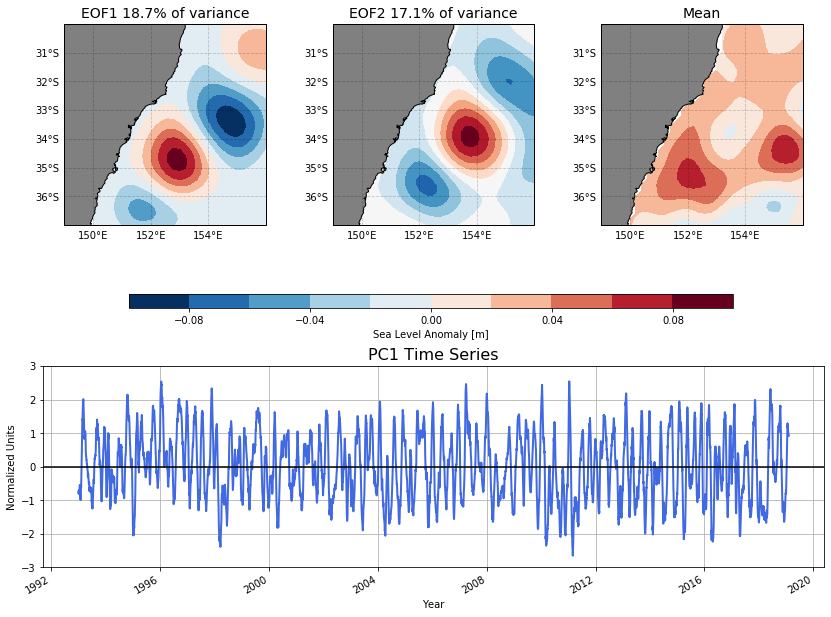

In [24]:
# Plot the leading EOF expressed as correlation in the EAC domain.
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

clevs = np.linspace(-.1, .1, 11)

fig = plt.figure(figsize=(14,10))
#ax = plt.subplot(1,3,1,projection=ccrs.PlateCarree())
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.7)
ax = plt.subplot(grid[0, :1],projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
ax.set_extent([149, 156, -37, -30])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xlocator = mticker.FixedLocator([149,150,152,154,156])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('EOF1 18.7% of variance', fontsize=14)

#ax = plt.subplot(1,3,2,projection=ccrs.PlateCarree())
ax = plt.subplot(grid[0, 1:2],projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
fill = eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
ax.set_extent([149, 156, -37, -30])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([149,150,152,154,156])
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('EOF2 17.1% of variance', fontsize=14)

#ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree())
ax = plt.subplot(grid[0, 2:3],projection=ccrs.PlateCarree())

feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
fill = mean_SL.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
ax.set_extent([149, 156, -37, -30])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xlocator = mticker.FixedLocator([149,150,152,154,156])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('Mean', fontsize=14)

cbar_ax = fig.add_axes([0.21, .485, .6, .02]) #left, bottom, width, height
fig.colorbar(fill, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Sea Level Anomaly [m]')

# Plot the leading PC time series.
#plt.figure(figsize=(14,3))
ax = plt.subplot(grid[1,:])
pc1[:, 0].plot(color='royalblue', linewidth=2)
#ax = plt.gca()
ax.axhline(0, color='k')
ax.set_ylim(-3, 3)
ax.set_xlabel('Year')
ax.set_ylabel('Normalized Units')
ax.set_title('PC1 Time Series', fontsize=16)
plt.grid(True)
savefig('SLA_EOF1_3.png', dpi=300,bbox_inches='tight')
plt.show()

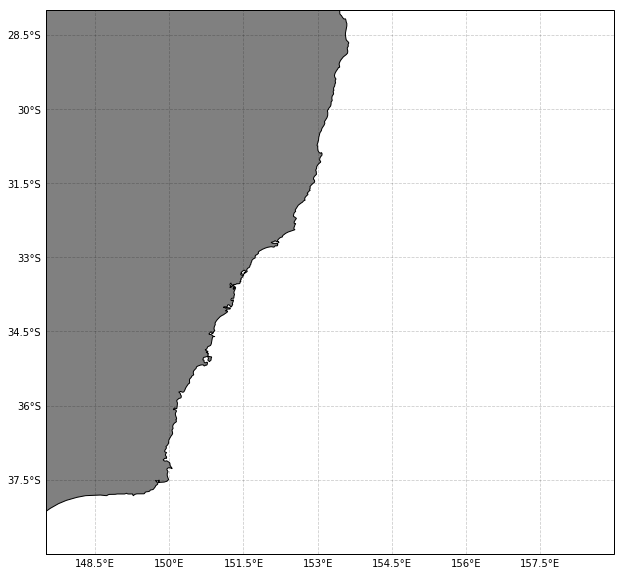

In [15]:
#blank plot for schematic
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

clevs = np.linspace(-.1, .1, 11)

fig = plt.figure(figsize=(14,10))
ax = plt.subplot(projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')

ax.set_extent([147.5, 159, -39, -28])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
savefig('schem_map.png', dpi=300,bbox_inches='tight')

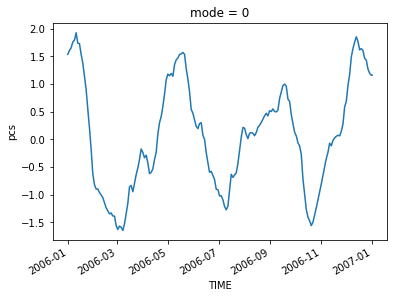

In [9]:
pc1[:,0].sel(TIME=slice('2006-01-01','2007-01-01')).plot()

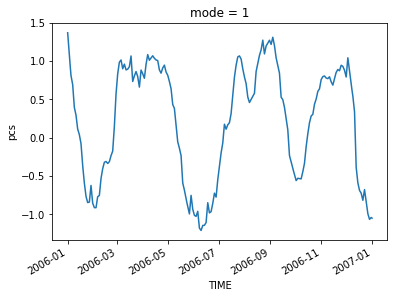

In [10]:
pc1[:,1].sel(TIME=slice('2006-01-01','2007-01-01')).plot()

## correlate PC1 with mean crosshelf velocity 33-34S

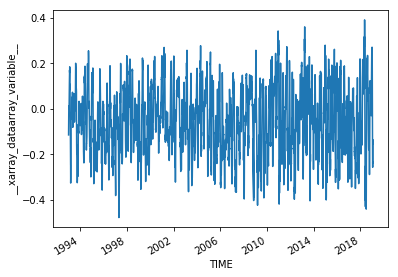

In [11]:
xs = xr.open_dataset('EAC_xshelf_u_curr_geostrophic_33S_34S_1993_2019.nc')
xs.__xarray_dataarray_variable__.plot()

In [12]:
x = pc1[:,0].values
y = xs.__xarray_dataarray_variable__.values

# With correlate:
# We must remove the means.
cc1 = np.correlate(x - x.mean(), y - y.mean())[0]
# And we must normalize by the number of points
# and the product of the standard deviations.
cc1 /= (len(x) * x.std() * y.std())

# with corrcoef:
cc2 = np.corrcoef(x, y)[0, 1]

print(cc1, cc2)

(-0.5522122939781611, -0.5522122939781611)


## Do Pearson's correlation with p-value

In [13]:
corr, p_value = stats.pearsonr(x, y)
p_value

0.0

## Now do it with confidence intervals

In [14]:
r, p, lo, hi = pearsonr_ci(x,y,alpha=0.001)
p

0.0

# Save pc1 as netcdf to correlate with separation latitude (from Paulina) in matlab

In [61]:
pc1[:,0].to_netcdf('dipole_pc1.nc')

## Now do the same for MADT

In [11]:
# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# # leading PC time series itself.
# solver = Eof(ds.GSL, weights=wgts)

# eof1 = solver.eofs(neofs=5)
# pc1 = solver.pcs(npcs=1, pcscaling=1)
# eof_frac=solver.varianceFraction()
# eof_frac

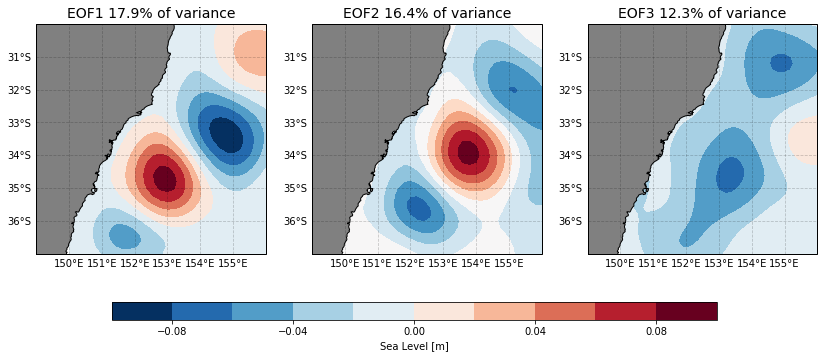

In [12]:
# Plot the leading EOF expressed as correlation in the Pacific domain.
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

fig = plt.figure(figsize=(14,5))
ax = plt.subplot(1,3,1,projection=ccrs.PlateCarree())

feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
ax.set_extent([149, 156, -37, -30])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('EOF1 17.9% of variance', fontsize=14)

ax = plt.subplot(1,3,2,projection=ccrs.PlateCarree())

feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
fill = eof1[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
ax.set_extent([149, 156, -37, -30])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('EOF2 16.4% of variance', fontsize=14)

ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree())

feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
fill = eof1[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False,
                             transform=ccrs.PlateCarree())
ax.set_extent([149, 156, -37, -30])
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
ax.set_title('EOF3 12.3% of variance', fontsize=14)

cbar_ax = fig.add_axes([0.2, -0.0, .6, .05]) #left, bottom, width, height
fig.colorbar(fill, cax=cbar_ax, orientation="horizontal",extend='both')
plt.xlabel('Sea Level [m]')
# # Plot the leading PC time series.
# plt.figure()
# pc1[:, 0].plot(color='b', linewidth=2)
# ax = plt.gca()
# ax.axhline(0, color='k')
# ax.set_ylim(-3, 3)
# ax.set_xlabel('Year')
# ax.set_ylabel('Normalized Units')
# ax.set_title('PC1 Time Series', fontsize=16)
savefig('SL_EOF1_3.png', dpi=300,bbox_inches='tight')
plt.show()

## Plot the first 2 PC's